# Group Member
### Rima Palli
### Manisha Yadav

In [1]:
#Import libraries
import pandas as pd
import numpy as np

from geopy.distance import geodesic

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [5]:
# Load the data
data = pd.read_csv('data/train.csv')

# Check for missing values and remove or impute
print(data.isnull().sum())  # Check missing values
data = data.dropna()  # Remove rows with missing values, or you can choose to fill them

# Convert datetime fields
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

# Feature Engineering
## Time Features
data['pickup_day_of_week'] = data['pickup_datetime'].dt.day_name()
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['dropoff_day_of_week'] = data['dropoff_datetime'].dt.day_name()
data['dropoff_hour'] = data['dropoff_datetime'].dt.hour
data['pickup_month'] = data['pickup_datetime'].dt.month

## Geospatial Features
def calculate_distance(row):
    pickup_point = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff_point = (row['dropoff_latitude'], row['dropoff_longitude'])
    return geodesic(pickup_point, dropoff_point).miles

data['trip_distance'] = data.apply(calculate_distance, axis=1)

# Calculate ride density per hour and pickup location
data['pickup_lat_rounded'] = data['pickup_latitude'].round(3)
data['pickup_long_rounded'] = data['pickup_longitude'].round(3)
ride_density = data.groupby(['pickup_hour', 'pickup_lat_rounded', 'pickup_long_rounded']).size().reset_index(name='ride_density')

# Merge back to the main dataframe if needed
data = pd.merge(data, ride_density, on=['pickup_hour', 'pickup_lat_rounded', 'pickup_long_rounded'], how='left')

# Save the prepared data
data.to_csv('data/clean_train.csv', index=False)


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


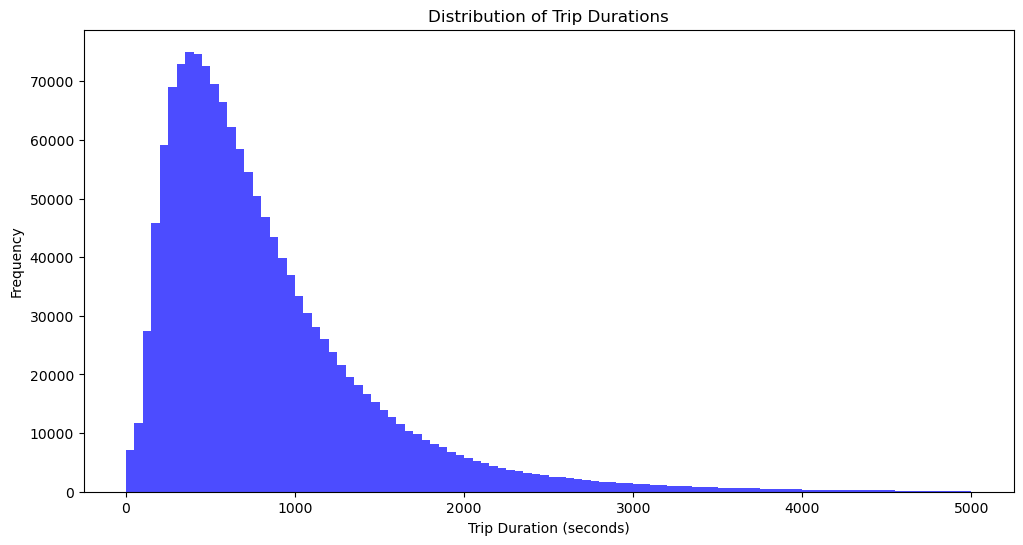

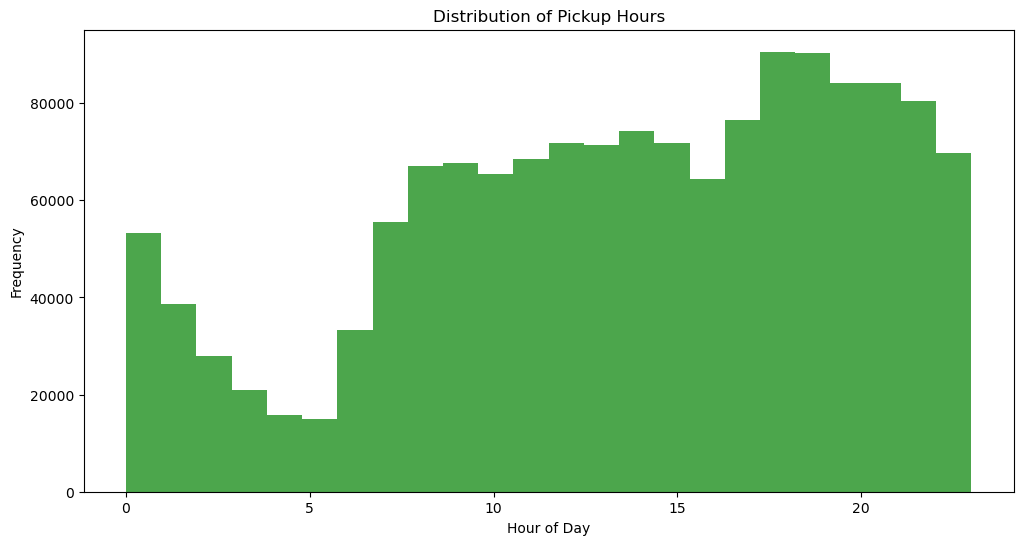

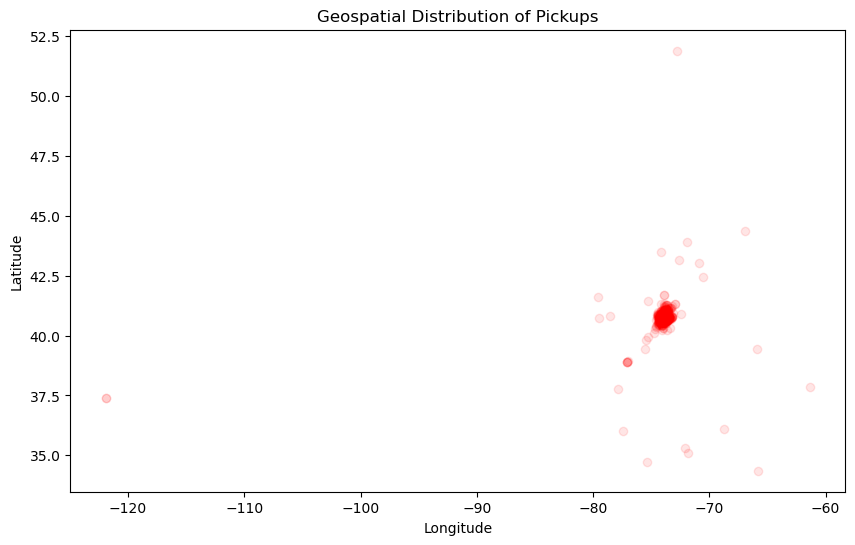

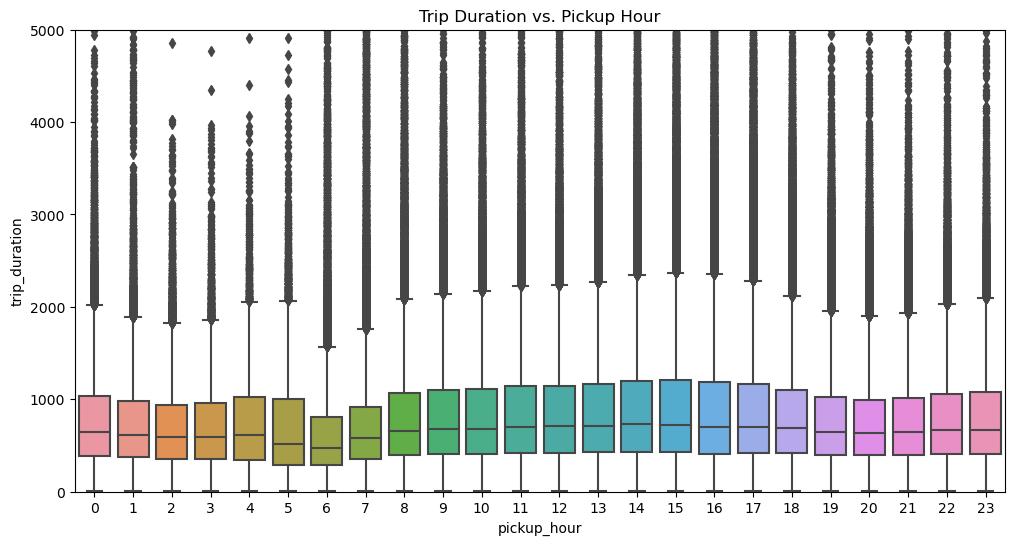

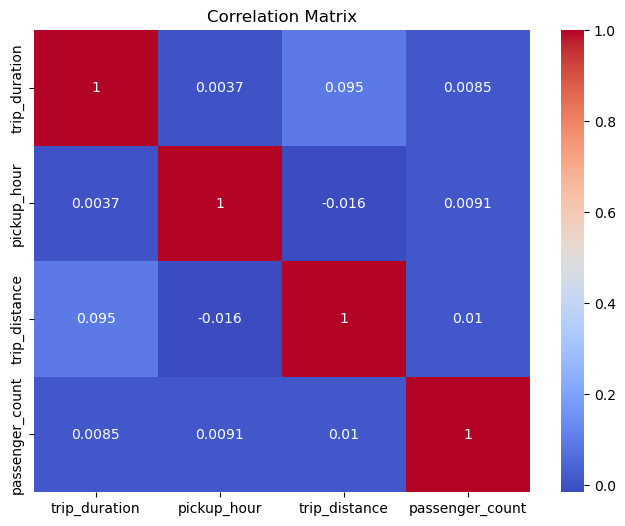

In [8]:
# Load the cleaned data
data = pd.read_csv('data/clean_train.csv')

# Visualizations
## Distribution of key variables
plt.figure(figsize=(12, 6))
plt.hist(data['trip_duration'], bins=100, color='blue', alpha=0.7, range=[0, 5000])
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(data['pickup_hour'], bins=24, color='green', alpha=0.7)
plt.title('Distribution of Pickup Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

# Geospatial distribution
plt.figure(figsize=(10, 6))
plt.scatter(data['pickup_longitude'], data['pickup_latitude'], color='red', alpha=0.1)
plt.title('Geospatial Distribution of Pickups')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Relationships between features and the target variable
# Trip duration vs. Pickup hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='pickup_hour', y='trip_duration', data=data)
plt.title('Trip Duration vs. Pickup Hour')
plt.ylim(0, 5000)  # Limiting to remove extreme outliers for better visualization
plt.show()

# Correlation Matrix
correlation = data[['trip_duration', 'pickup_hour', 'trip_distance', 'passenger_count']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [9]:
# Selecting features and target variable
features = ['pickup_hour', 'pickup_day_of_week', 'trip_distance', 'passenger_count']  # include categorical and numerical features
X = data[features]
y = data['trip_duration']  # target variable

# Data Preprocessing: One-hot encoding and scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['trip_distance', 'passenger_count', 'pickup_hour']),  # Numerical features
        ('cat', OneHotEncoder(), ['pickup_day_of_week'])  # Categorical features
    ])

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit and transform training data, and transform testing data
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

# save the preprocessor for future use in deployment
import joblib
preprocessor_filename = "preprocessor.save"
joblib.dump(preprocessor, preprocessor_filename)


['preprocessor.save']

In [10]:
# Define XGBoost model
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')

# Parameters for cross-validation
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_prepared, y_train)

# Best estimator
best_xgb = grid_search.best_estimator_


In [11]:
# Predictions with XGBoost
xgb_predictions = best_xgb.predict(X_test_prepared)
xgb_rmse = sqrt(mean_squared_error(y_test, xgb_predictions))

print("XGBoost RMSE:", xgb_rmse)

XGBoost RMSE: 3146.9278362405266


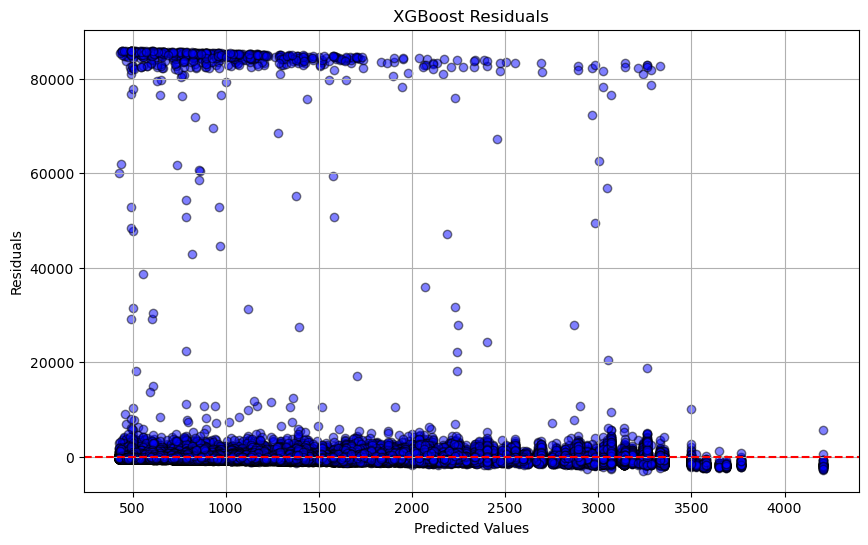

In [27]:
#xgb_predictions and y_test
residuals = y_test - xgb_predictions

# Creating the plot
plt.figure(figsize=(10, 6))
plt.scatter(xgb_predictions, residuals, alpha=0.5, color='blue', edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--')  # Adding a horizontal line at zero for reference
plt.title('XGBoost Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)  # Adding a grid for better readability
plt.show()


In [12]:
# Define and fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_prepared, y_train)

# Predicting the Test set results
rf_predictions = rf_model.predict(X_test_prepared)
rf_rmse = sqrt(mean_squared_error(y_test, rf_predictions))

print("Random Forest RMSE:", rf_rmse)


Random Forest RMSE: 3635.5625909430837


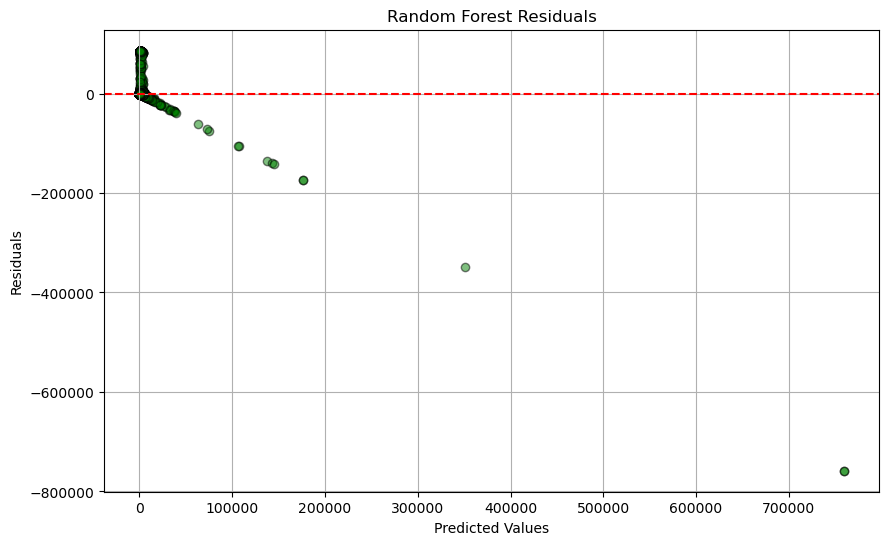

In [28]:
#rf_predictions and y_test
residuals_rf = y_test - rf_predictions

# Creating the plot
plt.figure(figsize=(10, 6))
plt.scatter(rf_predictions, residuals_rf, alpha=0.5, color='green', edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--')  # Adding a horizontal line at zero for reference
plt.title('Random Forest Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)  # Adding a grid for better readability
plt.show()

In [13]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train_lstm = np.reshape(X_train_prepared, (X_train_prepared.shape[0], 1, X_train_prepared.shape[1]))
X_test_lstm = np.reshape(X_test_prepared, (X_test_prepared.shape[0], 1, X_test_prepared.shape[1]))

# Define LSTM model
model = Sequential([
    LSTM(50, input_shape=(1, X_train_prepared.shape[1])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Fit model
model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)

# Predicting the Test set results
lstm_predictions = model.predict(X_test_lstm).flatten()
lstm_rmse = sqrt(mean_squared_error(y_test, lstm_predictions))

print("LSTM RMSE:", lstm_rmse)


Epoch 1/50


2024-05-14 20:53:54.901790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-14 20:53:54.902518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-14 20:53:54.902847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31908/31908 [==============================] - 13s 380us/step - loss: 35135964.0000
Epoch 2/50
31908/31908 [==============================] - 12s 384us/step - loss: 34766988.0000
Epoch 3/50
31908/31908 [==============================] - 12s 382us/step - loss: 34661000.0000
Epoch 4/50
31908/31908 [==============================] - 12s 381us/step - loss: 34594604.0000
Epoch 5/50
31908/31908 [==============================] - 12s 382us/step - loss: 34567788.0000
Epoch 6/50
31908/31908 [==============================] - 100s 3ms/step - loss: 34549252.0000
Epoch 7/50
31908/31908 [==============================] - 12s 373us/step - loss: 34535408.0000
Epoch 8/50
31908/31908 [==============================] - 12s 375us/step - loss: 34525120.0000
Epoch 9/50
31908/31908 [==============================] - 12s 383us/step - loss: 34517864.0000
Epoch 10/50
31908/31908 [==============================] - 12s 384us/step - loss: 34512168.0000
Epoch 11/50
31908/31908 [==============================] - 12

2024-05-14 21:05:53.688050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-14 21:05:53.688446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-14 21:05:53.688816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13675/13675 [==============================] - 3s 190us/step
LSTM RMSE: 3144.094041688496


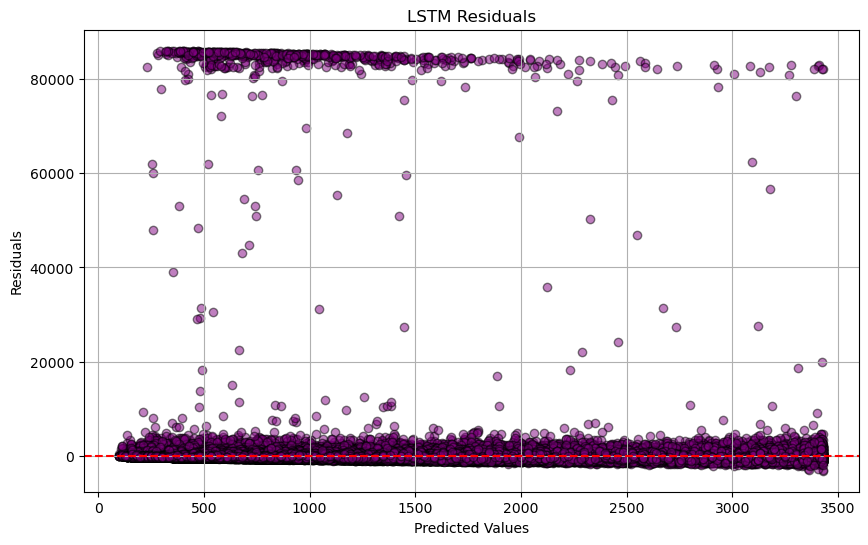

In [29]:
#lstm_predictions and y_test
residuals_lstm = y_test - lstm_predictions

# Creating the plot
plt.figure(figsize=(10, 6))
plt.scatter(lstm_predictions, residuals_lstm, alpha=0.5, color='purple', edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--')  # Adding a horizontal line at zero for reference
plt.title('LSTM Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)  # Adding a grid for better readability
plt.show()

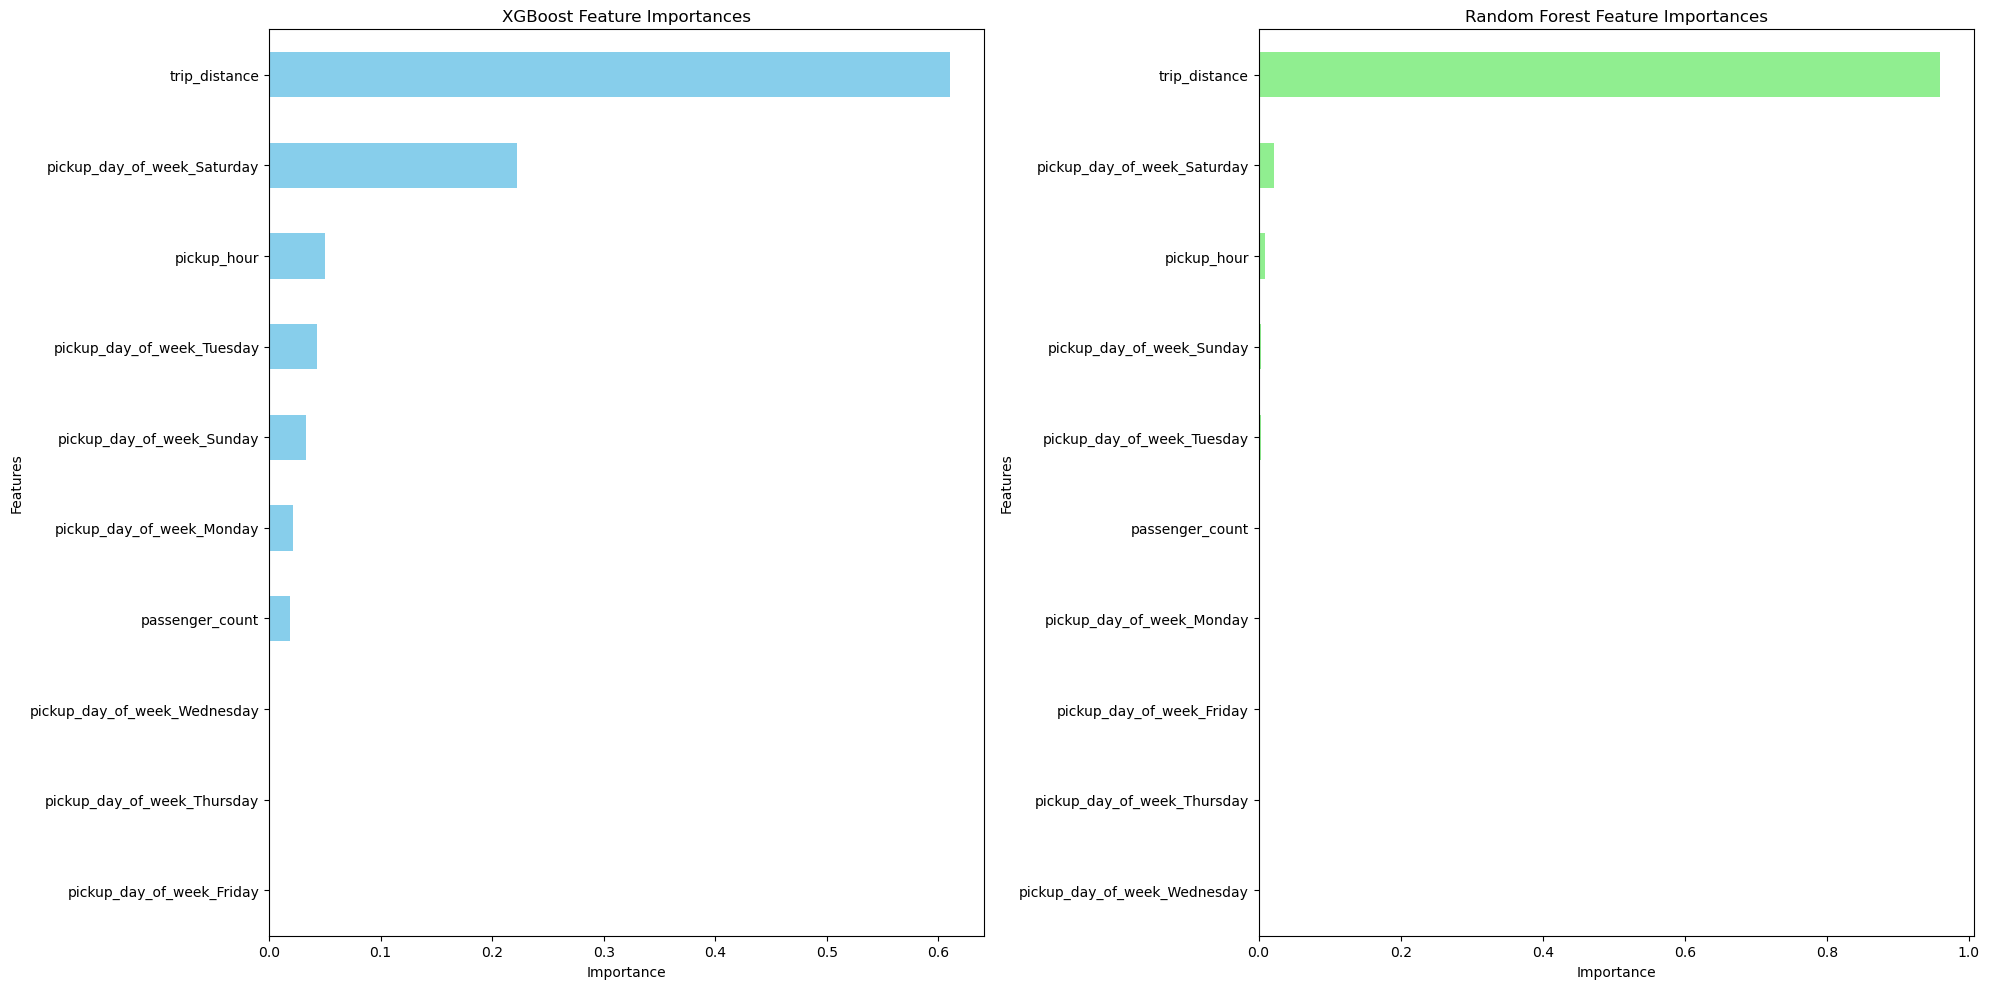

In [23]:
# 'preprocessor' is ColumnTransformer with a StandardScaler and OneHotEncoder
feature_names_num = ['trip_distance', 'passenger_count', 'pickup_hour']  # numerical features
feature_names_cat = preprocessor.named_transformers_['cat'].get_feature_names_out()  # categorical features transformed

# Combining all feature names
all_features = feature_names_num + list(feature_names_cat)

# Feature importances 
xgb_importances = pd.Series(best_xgb.feature_importances_, index=all_features)
rf_importances = pd.Series(rf_model.feature_importances_, index=all_features)

# Adjust the figure size 
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Increased width to 20

# Plot XGBoost Feature Importance
xgb_importances.sort_values().plot(kind='barh', ax=axs[0], color='skyblue')
axs[0].set_title('XGBoost Feature Importances')
axs[0].set_xlabel('Importance')
axs[0].set_ylabel('Features')

# Plot Random Forest Feature Importance
rf_importances.sort_values().plot(kind='barh', ax=axs[1], color='lightgreen')
axs[1].set_title('Random Forest Feature Importances')
axs[1].set_xlabel('Importance')
axs[1].set_ylabel('Features')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


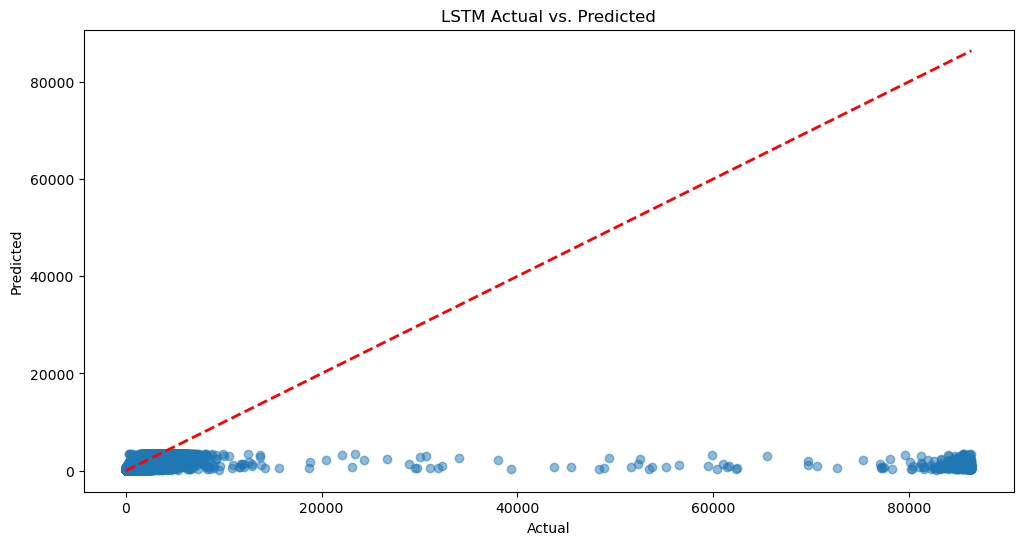

In [20]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, lstm_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('LSTM Actual vs. Predicted')
plt.show()


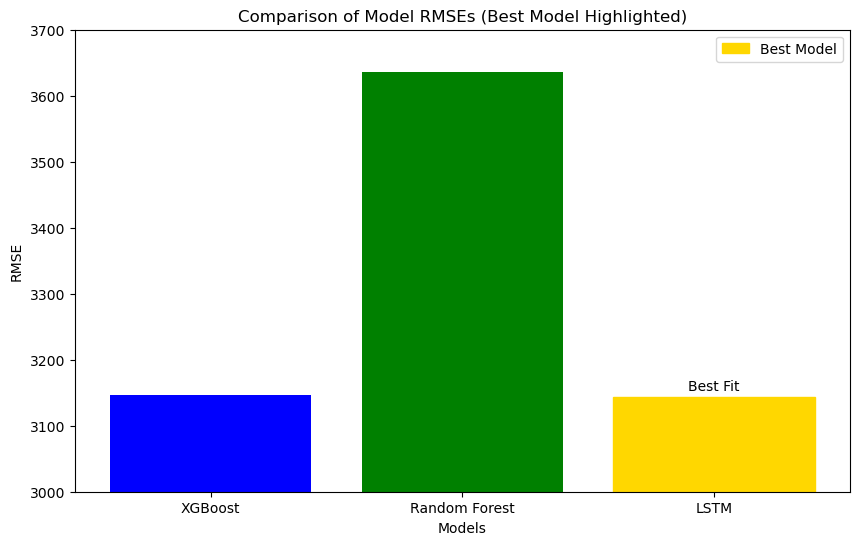

In [30]:
# Model names and their corresponding RMSE values
models = ['XGBoost', 'Random Forest', 'LSTM']
rmse_values = [xgb_rmse, rf_rmse, lstm_rmse]

# Creating the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, rmse_values, color=['blue', 'green', 'red'])

# Highlighting the best model (lowest RMSE)
best_model_index = rmse_values.index(min(rmse_values))
bars[best_model_index].set_color('gold')  # Change color to gold for the best model
bars[best_model_index].set_label('Best Model')

# Adding text annotation
ax.text(best_model_index, rmse_values[best_model_index] + 10, 'Best Fit', color='black', ha='center')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Comparison of Model RMSEs (Best Model Highlighted)')
plt.ylim(3000, 3700)  # Adjust to fit the annotation if needed
plt.legend()

# Show the plot
plt.show()